In [1]:
import os
import shutil
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import random


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)



2.6.4


In [2]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [6]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
# Each species' pictures are stored in a separate directory which
# names are as follows:
labels = [
    "Species1",
    "Species2",
    "Species3",
    "Species4",
    "Species5",
    "Species6",
    "Species7",
    "Species8"
]


input_shape = (96, 96, 3)
epochs = 200
batch_size=32

In [6]:
initial_dataset_dir = '../input/plants/images'

## How many images per species ?

Text(0.5, 1.0, 'Number of training pictures per species')

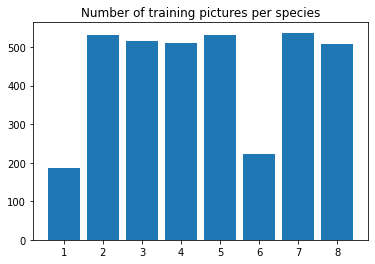

In [9]:
number_by_species={}

label_counts = []
for species in labels:
    n=len(os.listdir("{}/{}/".format(initial_dataset_dir, species)))
    number_by_species[species]=n
    label_counts.append(n)

plt.bar(np.arange(1,9), label_counts)
plt.title("Number of training pictures per species")

## To sum up:
### 3542 pictures of which:
- 186 of species 1
- 532 of species 2
- 515 of species 3
- 511 of species 4
- 531 of species 5
- 222 of species 6
- 537 of species 7
- 508 of species 8

Of size (96 x 96) pixels encoded in RGB space (depth = 3 channels)

### Input $ I \in \{0, 1, 2 ... 255\}^{96 \times 96 \times 3}$
### Output $ K \in [0;1]^{8} $

# Data processing : loading, balancing, augmentation


## Creating the training/validation split of the dataset


In [10]:
if (os.path.exists('./dataset')==False):
    os.mkdir('./dataset')
    

new_dataset_dir='./dataset'
validation_split=0.1
num_species=8

In [11]:
# DO IT ONCE THEN COMMENT BUT CAN BE REDO IF NEEDED

# Random training/val split, by splitting equally each species

train_subset=[]
valid_subset=[]

def create_folders():
    path_train=os.path.join(new_dataset_dir,'training')
    path_valid=os.path.join(new_dataset_dir,'validation')
    isExist_train = os.path.exists(path_train)
    isExist_valid = os.path.exists(path_valid)
    if (isExist_train==False):
        os.mkdir(path_train)
    if (isExist_valid==False):
        os.mkdir(path_valid)
    
    for i in range(1,num_species+1):
        path_train_i=os.path.join(new_dataset_dir,'training/Species'+str(i))
        path_valid_i=os.path.join(new_dataset_dir,'validation/Species'+str(i))
        isExist_train_i = os.path.exists(path_train_i)
        isExist_valid_i = os.path.exists(path_valid_i)
        if (isExist_train_i==False):
            os.mkdir(path_train_i)
        if (isExist_valid_i==False):
            os.mkdir(path_valid_i)
    



def clear_folder(mydir):
    filelist = [ f for f in os.listdir(mydir) ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))


create_folders()


for i in range(1,num_species+1):
    
    training_species_i=os.path.join(new_dataset_dir,'training/Species'+str(i))
    valid_species_i=os.path.join(new_dataset_dir,'validation/Species'+str(i))
    clear_folder(training_species_i)
    clear_folder(valid_species_i)
    
    filenames = next(os.walk(os.path.join(initial_dataset_dir,'Species'+str(i))))[2]   
    random.Random(seed).shuffle(filenames)
    num_valid_samples = int(len(filenames)*validation_split)
    add_to_train=filenames[:-num_valid_samples]
    add_to_valid=filenames[-num_valid_samples:]
    train_subset = train_subset+add_to_train
    valid_subset = valid_subset+add_to_valid
    for name in add_to_train:
        shutil.copy(os.path.join(initial_dataset_dir,'Species'+str(i)+'/'+name),training_species_i)    
    for name in add_to_valid:
        shutil.copy(os.path.join(initial_dataset_dir,'Species'+str(i)+'/'+name),valid_species_i)
    
    
        

print(len(train_subset))
print(len(valid_subset))
print(len(train_subset)+len(valid_subset))

    


3191
351
3542


## Balancing the training dataset : over/undersampling

In [ ]:
# Why balancing only the training datasets and not the val ones :

In [12]:
# FIRST APPROACH : OVERSAMPLING

import random

# We randomly duplicate image from the minoritary species until their number reach the max one among
# all the initial number_by_species.

max_number_by_species = (int) (max(number_by_species.values())*(1-validation_split))+1

for i in range(1,9):
    dir_species_i='./dataset/training/Species'+str(i)
    filenames=os.listdir(dir_species_i)
    file_to_duplicate_names=[]
    number=len(filenames)
    q=max_number_by_species//number
    r=max_number_by_species%number
    if (q>1):
        file_to_duplicate_names=(q-1)*filenames
    
    for i in range (r):       
        to_add=filenames[i]
        file_to_duplicate_names.append(to_add)
    random.Random(seed).shuffle(file_to_duplicate_names)
    
    print(len(file_to_duplicate_names))
    name_occur={}
    for name in filenames:
        name_occur[name]=1
    
   
    for name in file_to_duplicate_names:
        
        shutil.copy(dir_species_i+'/'+name,dir_species_i+'/'+name+str(name_occur[name]))
        name_occur[name]=name_occur[name]+1
        
 
        
    
    
# =====> Duplicate images from the training dataset mult times might involve overfitting ?
# cf noaug_basic_model performances on curve
    
    

    
    

316
5
20
24
6
284
0
26


In [14]:
# # ALTERNATIVELY TRYING UNDERSAMPLING


# min_number_by_species = (int) (min(number_by_species.values())*(1-validation_split))+1

# for i in range(1,9):
#     dir_species_i='./dataset/training/Species'+str(i)
#     filenames=os.listdir(dir_species_i)
#     number=len(filenames)
#     np.random.shuffle(filenames)
#     for k in range(min_number_by_species,number):
#         os.remove('./dataset/training/Species'+str(i)+'/'+filenames[k])
    
 



In [13]:
T=0
V=0


for i in range(1,9):
    t=len(os.listdir('/kaggle/working/dataset/training/Species'+str(i)))
    v=len(os.listdir('/kaggle/working/dataset/validation/Species'+str(i)))
    T=T+t
    V=V+v
    print("Species "+str(i)+" :")
    print()
    print("training : ",t, " elements ; validation : ",v," elements ; total : ",v+t, " elements" )
    print("----------------------------------------------------------")
    
print()
print("There is at total ",(T,V), " elements in dataset")

Species 1 :

training :  484  elements ; validation :  18  elements ; total :  502  elements
----------------------------------------------------------
Species 2 :

training :  484  elements ; validation :  53  elements ; total :  537  elements
----------------------------------------------------------
Species 3 :

training :  484  elements ; validation :  51  elements ; total :  535  elements
----------------------------------------------------------
Species 4 :

training :  484  elements ; validation :  51  elements ; total :  535  elements
----------------------------------------------------------
Species 5 :

training :  484  elements ; validation :  53  elements ; total :  537  elements
----------------------------------------------------------
Species 6 :

training :  484  elements ; validation :  22  elements ; total :  506  elements
----------------------------------------------------------
Species 7 :

training :  484  elements ; validation :  53  elements ; total :  537  elem

## Vizualising data

In [14]:
training_dir = os.path.join(new_dataset_dir, 'training')
validation_dir = os.path.join(new_dataset_dir, 'validation')

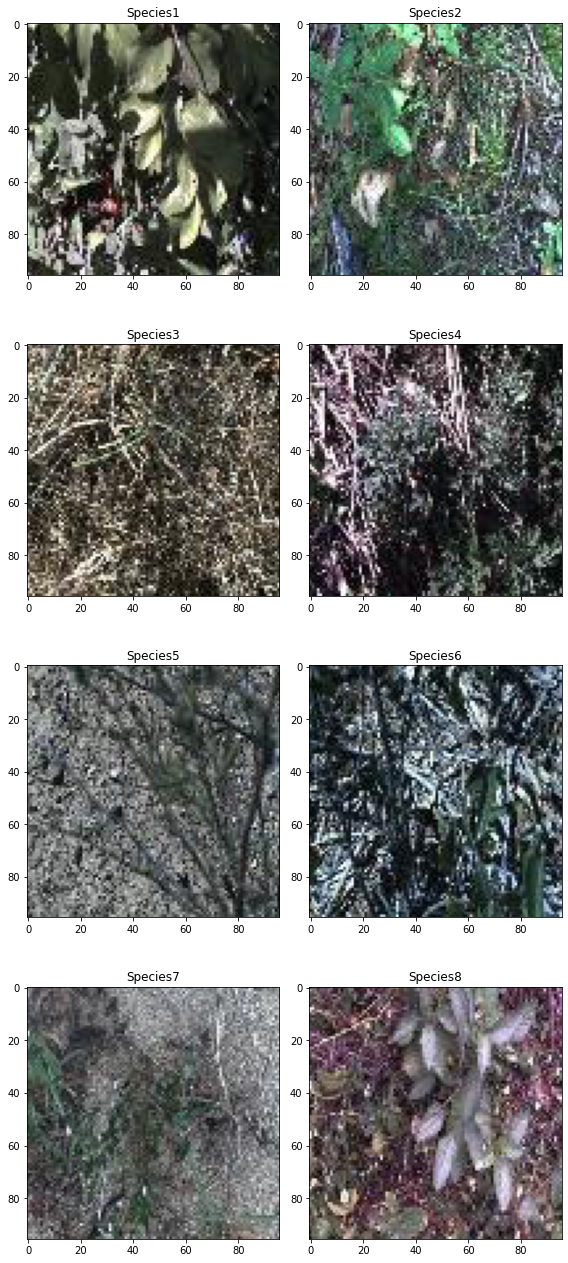

In [15]:
#vizualising data 

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]        # 20

num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/training/{}/'.format(new_dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(new_dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()



# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
   

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True
                                              ,seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False
                                              ,seed=seed)


#8===>32 batch size

# to try : powers of 2

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [17]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]


  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

 

  return batch

(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0.]
Label: 2
Class name: Species3


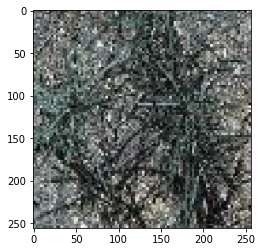

In [18]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

## Data Augmentation

In [19]:
# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )

Rotation: {'theta': 9.357769669431228, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 7, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1.0528624255950256, 'zy': 0.8472059517780158, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

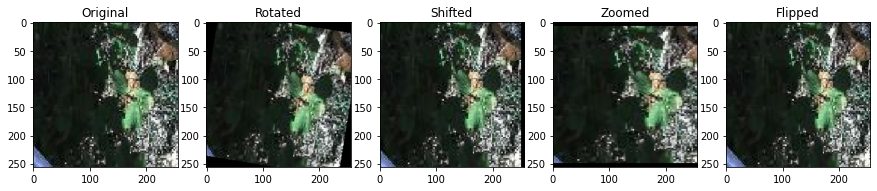

In [19]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=10)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96,96))
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96,96))
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96,96))
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96,96))
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

# Training with and without data augmentation

In [28]:
# Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rescale=1/255.) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(rescale=1/255.)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(256,256),
                                                           color_mode='rgb',
                                                           classes=labels, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [29]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        height_shift_range=10,
                                        width_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 3191 images belonging to 8 classes.


In [23]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model





In [24]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [25]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 8.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0     

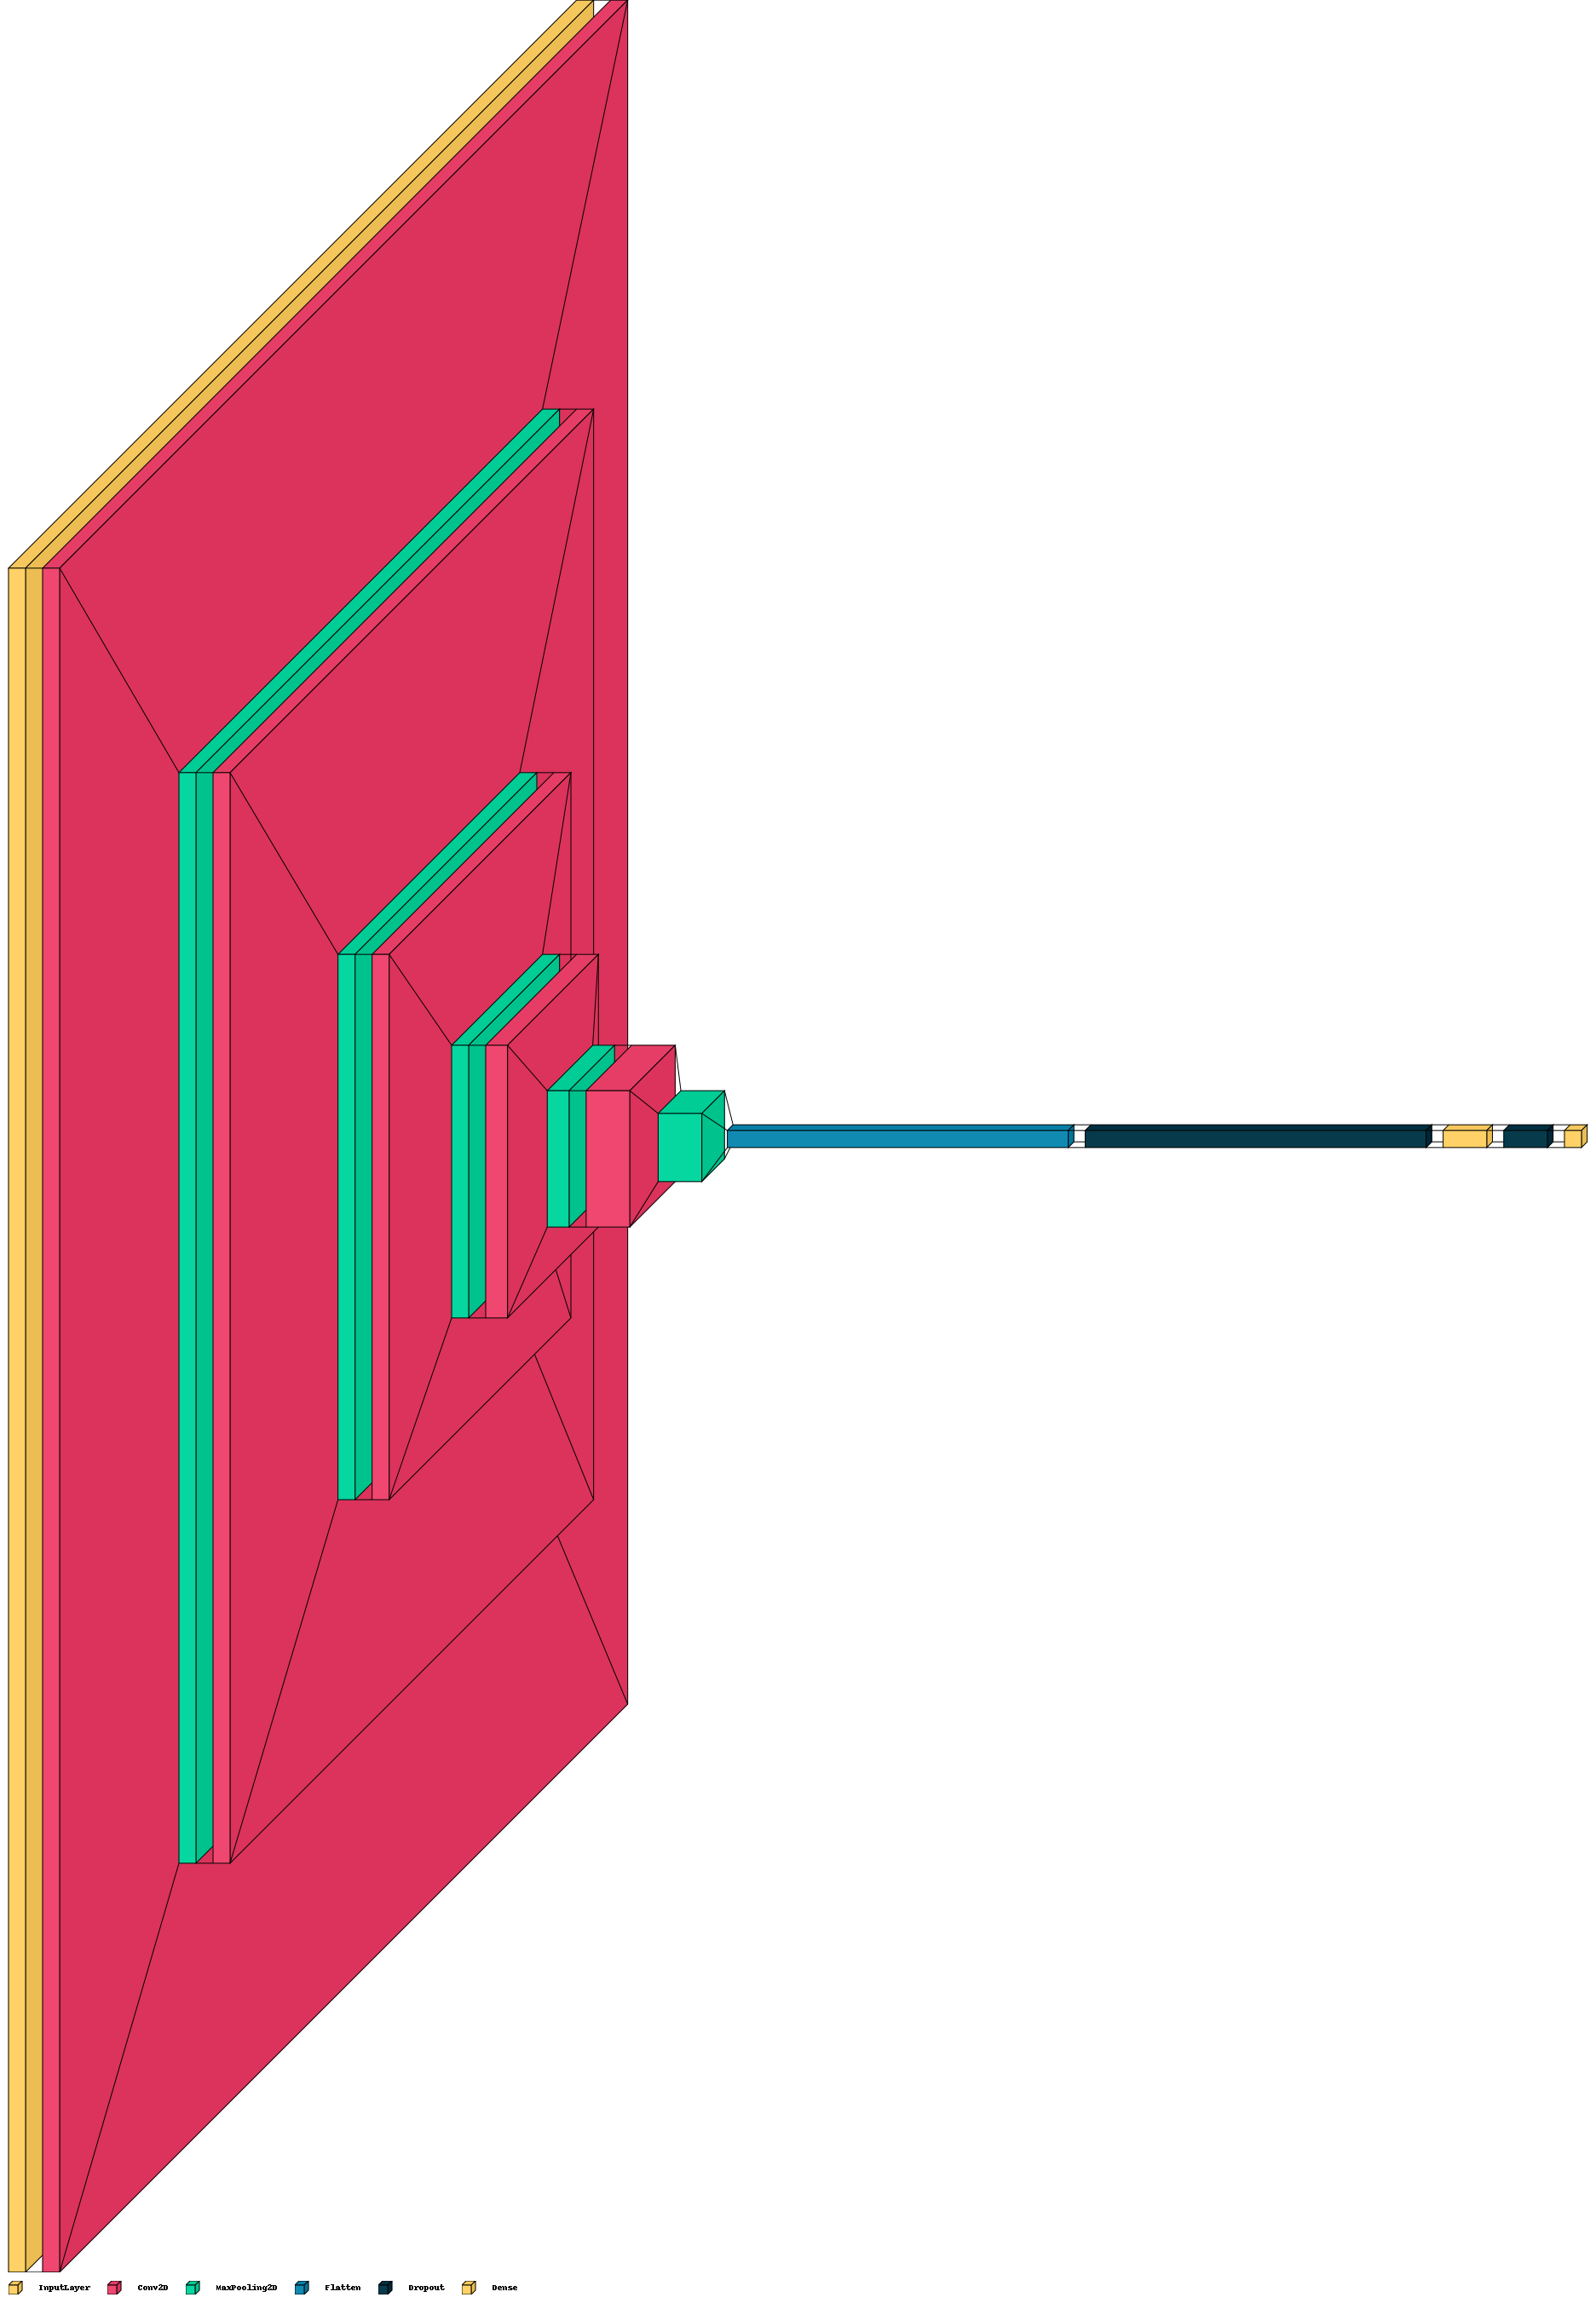

In [30]:
import visualkeras

input_shape=(256,256,3)

# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [31]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks ,
).history

Epoch 1/200
100/100 [==============================] - 10s 98ms/step - loss: 2.7522 - accuracy: 0.2078 - val_loss: 1.6931 - val_accuracy: 0.3134
Epoch 2/200
100/100 [==============================] - 8s 80ms/step - loss: 1.7182 - accuracy: 0.3319 - val_loss: 1.7192 - val_accuracy: 0.2991
Epoch 3/200
100/100 [==============================] - 8s 83ms/step - loss: 1.6012 - accuracy: 0.3949 - val_loss: 1.5053 - val_accuracy: 0.4444
Epoch 4/200
100/100 [==============================] - 8s 81ms/step - loss: 1.4190 - accuracy: 0.4582 - val_loss: 1.3406 - val_accuracy: 0.4786
Epoch 5/200
100/100 [==============================] - 8s 82ms/step - loss: 1.2823 - accuracy: 0.5274 - val_loss: 1.2680 - val_accuracy: 0.5014
Epoch 6/200
100/100 [==============================] - 8s 80ms/step - loss: 1.1969 - accuracy: 0.5559 - val_loss: 1.2146 - val_accuracy: 0.5499
Epoch 7/200
100/100 [==============================] - 8s 82ms/step - loss: 1.0901 - accuracy: 0.5939 - val_loss: 1.2904 - val_accuracy

KeyboardInterrupt: 

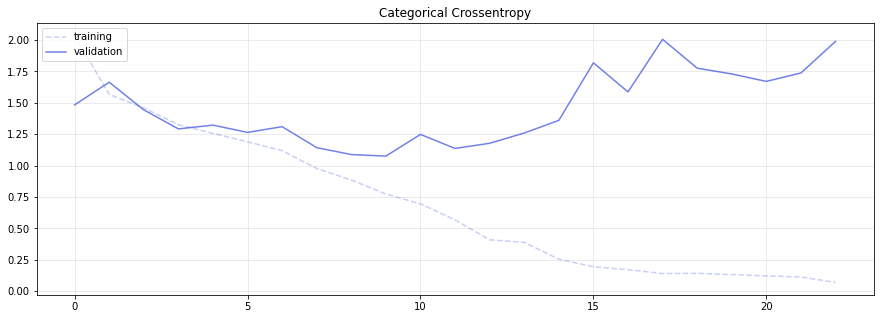

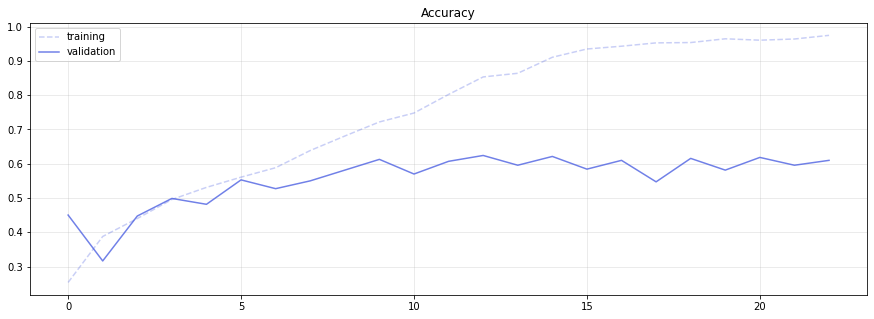

In [28]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")

In [ ]:
import shutil
shutil.make_archive("basic_CNN_NoAug", 'zip', 'data_augmentation_experiments/CNN_NoAug_Best')   

In [32]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
100/100 [==============================] - 48s 483ms/step - loss: 1.3964 - accuracy: 0.5296 - val_loss: 1.2028 - val_accuracy: 0.5840
Epoch 2/200
100/100 [==============================] - 49s 488ms/step - loss: 1.1376 - accuracy: 0.5876 - val_loss: 1.1381 - val_accuracy: 0.5926
Epoch 3/200
100/100 [==============================] - 49s 488ms/step - loss: 1.0607 - accuracy: 0.6246 - val_loss: 1.1084 - val_accuracy: 0.5840
Epoch 4/200
100/100 [==============================] - 49s 487ms/step - loss: 1.0332 - accuracy: 0.6249 - val_loss: 1.0242 - val_accuracy: 0.6353
Epoch 5/200
100/100 [==============================] - 49s 485ms/step - loss: 1.0172 - accuracy: 0.6261 - val_loss: 1.2106 - val_accuracy: 0.5670
Epoch 6/200
100/100 [==============================] - 49s 485ms/step - loss: 0.9524 - accuracy: 0.6653 - val_loss: 1.1794 - val_accuracy: 0.6068
Epoch 7/200
100/100 [==============================] - 49s 489ms/step - loss: 0.9583 - accuracy: 0.6528 - val_loss: 1.0553 -

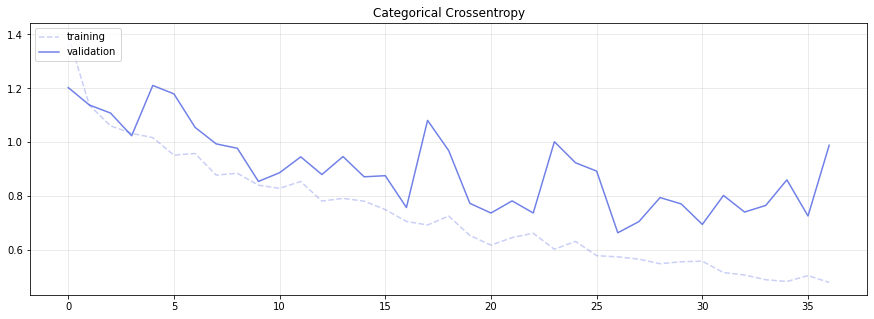

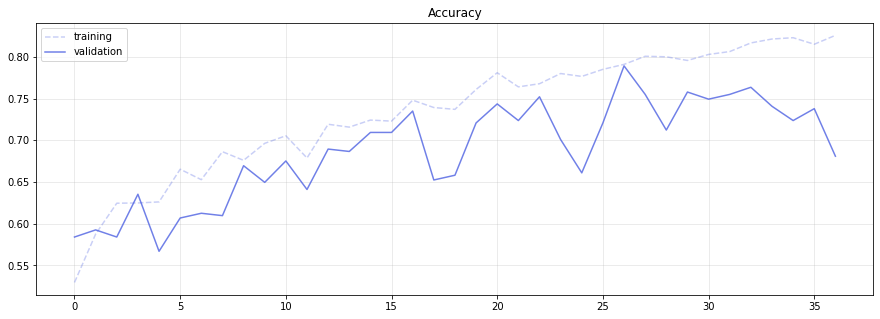

In [39]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig('cat_crossentropy_evol')

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'],label='training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'],label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('accuracy_evol')
plt.show()


In [34]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

In [35]:
import shutil
shutil.make_archive("course_CNN_Aug", 'zip', 'data_augmentation_experiments/CNN_Aug_Best')   

'/kaggle/working/course_CNN_Aug.zip'

In [ ]:
# INTERESTING : NO DATA AUGMENATION -> HIGHER ACCURACY BUT WAY HIGHER CATEGORICAL CROSS ENTR WHILE
# DATA AUGM -> A BIT LOWER ACC BUT LOWER CAT CROSS ENT

## VGG16

In [80]:
epochs = 200
batch_size=8

In [81]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image data generators with data augmentation, adapted to VGG19 which already have a preprocess


# Create an instance of ImageDataGenerator with Data Augmentation for training
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        height_shift_range=10,
                                        width_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect'
                                       
                                        ) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       color_mode='rgb',
                                                       classes=labels, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)


valid_data_gen = ImageDataGenerator()



valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)





Found 3191 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

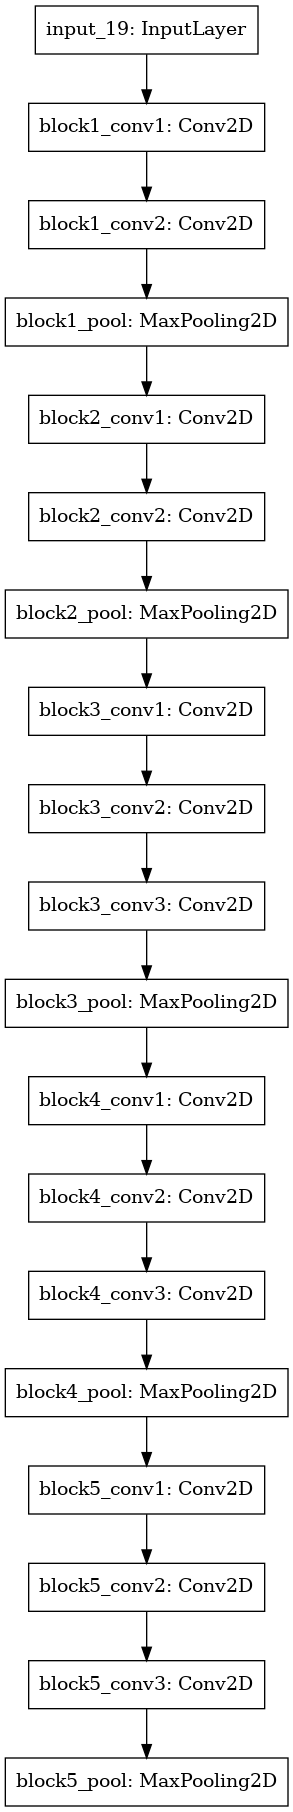

In [82]:
# Download and plot the VGG19 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [83]:
# We take the supernet as feature extractor, freeze its weights and "connect" it to a FCNN adapted
# to our pb at the top of the network.
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)

x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 4608)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 4608)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 2056  

In [84]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='VGG19_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
399/399 [==============================] - 52s 129ms/step - loss: 2.0259 - accuracy: 0.1360 - val_loss: 2.0217 - val_accuracy: 0.1510
Epoch 2/200
399/399 [==============================] - 51s 127ms/step - loss: 2.4087 - accuracy: 0.1416 - val_loss: 2.0210 - val_accuracy: 0.1510
Epoch 3/200
399/399 [==============================] - 50s 126ms/step - loss: 2.0845 - accuracy: 0.1495 - val_loss: 2.0208 - val_accuracy: 0.1510
Epoch 4/200
399/399 [==============================] - 51s 127ms/step - loss: 2.0336 - accuracy: 0.1501 - val_loss: 2.0209 - val_accuracy: 0.1510
Epoch 5/200
399/399 [==============================] - 51s 127ms/step - loss: 2.0281 - accuracy: 0.1473 - val_loss: 2.0208 - val_accuracy: 0.1510
Epoch 6/200
399/399 [==============================] - 50s 125ms/step - loss: 2.0255 - accuracy: 0.1448 - val_loss: 2.0214 - val_accuracy: 0.1453
Epoch 7/200
399/399 [==============================] - 50s 125ms/step - loss: 2.0248 - accuracy: 0.1420 - val_loss: 2.0209 -